<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/FINANCE/MertonLifecycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Merton-Style Lifecycle Consumption and Portfolio Choice via Amortization-Based Approximation

This notebook was created to explore Amortization-Based Withdrawals (ABW) as a framework for modeling both savings and spending decisions across the lifecycle. The goal is to understand how this pragmatic formulation relates to the theoretically derived optimal-consumption and portfolio-choice problem in the academic literature. Specifically, the notebook:

- Draws from the Merton (1969, 1971) continuous-time solution for optimal consumption and portfolio choice.  
- Seeks to describe how, under specific simplifying assumptions, the Hamilton-Jacobi-Bellman (HJB) dynamic programming solution can reduce to the simpler ABW-style formulas implemented here.  
- Incorporates human capital into the framework and adds realism by considering time-varying expected returns based on valuation ratios (CAPE).  
- Instead of specifying an asset allocation exogenously, assumes a constant relative risk aversion (CRRA) utility function to show how a Merton-style equity-share rule, combined with human capital, can generate an endogenous glide path similar to that used in target-date funds.

Using Monte Carlo simulation, we model many stochastic lifecycle paths and summarize the resulting median and 10th-90th percentile bands for:

- Financial wealth  
- Total wealth (including human capital)  
- Consumption  
- Equity share (glide path)  
- Savings rate during the pre-retirement phase  
- Withdrawal rate (as a proportion of financial wealth at the start of retirement), facilitating comparison with "safe withdrawal rate" benchmarks in the financial-planning literature.

**Note**: Although the core of the text and the code were handwritten, LLMs were used to make improvements to both.

## Step 1 – Merton’s Problem, HJB, and Parameters

### 1.1 Continuous-Time Merton Problem

We maximize expected discounted utility of consumption:

$$
\max_{c_t,\pi_t}
\mathbb{E}\!\left[\int_0^T e^{-\rho t} u(c_t)\,dt + e^{-\rho T} B(W_T)\right]
$$

subject to the wealth dynamics

$$
dW_t = \big[rW_t + \pi_t(\mu - r)W_t + y_t - c_t\big]\,dt
       + \pi_t\sigma W_t\,dZ_t
$$

and with CRRA utility

$$
u(c) = \frac{c^{1-\gamma}}{1-\gamma}, \qquad \gamma>0.
$$

The Hamilton-Jacobi-Bellman equation is

$$
0 = \max_{c,\pi} \Big\{
u(c) + V_t
+ V_W\big[(r+\pi(\mu-r))W - c\big]
+ \tfrac{1}{2}V_{WW}\pi^2\sigma^2 W^2
\Big\}.
$$

First-order conditions:

- Consumption:  $u'(c_t^*) = V_W(t,W_t)$  
  → implies $c_t^* = \kappa(t)\,W_t$ (consume a fraction of wealth).  
- Portfolio:  
  $$
  \pi_t^* = -\frac{\mu-r}{\sigma^2}\frac{V_W}{W\,V_{WW}}
  \;\Rightarrow\;
  \pi_t^* = \frac{\mu-r}{\gamma\sigma^2}
  $$
  under CRRA and constant parameters.

Hence, optimal consumption is proportional to total current wealth, with the proportionality factor $\kappa(t)$ evolving over time, and the optimal risky asset allocation simply equals the Sharpe ratio divided by the coefficient of relative risk aversion!

### 1.2 Discrete Approximation

We do NOT solve the HJB through dynamic programming (computationally intensive but doable).

Instead, we:

- Approximate $\kappa(t)$ with the ABW annuity fraction  
- Use the myopic Merton portfolio rule on a yearly basis  
- Simulate discrete wealth dynamics given the parameters of the risky asset and initial conditions.  

These steps involve several simplifying assumptions that make the model tractable while preserving its essential economic content. We assume that returns, consumption, and portfolio choices can be updated once per year, and that the underlying investment opportunities evolve slowly enough that annual rebalancing is an adequate approximation to the continuous-time setting. This effectively discretizes Merton's smooth optimal control problem into an annual decision problem that is more interpretable and computationally transparent.

The ABW-style consumption rule replaces stochastic wealth growth with a deterministic planning rate, implying that agents plan based on expected returns rather than specific market outcomes. This captures the idea of "consumption smoothing under expected conditions", while stochastic deviations are explored later in the Monte Carlo simulation. Similarly, the myopic Merton rule assumes investors react primarily to the local trade-off between expected excess return and variance rather than forecasting future shifts in these parameters. This seems to be a reasonable approximation when return predictability is modest and labor income is relatively stable.

Intuitively, these approximations amount to assuming that people plan their spending and investment allocations with a long-run horizon in mind, revising decisions periodically as conditions evolve, rather than continuously optimizing every instant. As the simulations later show, this approach seems to capture the main lifecycle mechanisms of consumption smoothing without requiring full stochastic control machinery.


### 1.3 Parameter Descriptions

| Parameter | Meaning / Role |
|:--|:--|
| `age_start`, `age_retire`, `age_terminal` | Define start, retirement, and terminal ages. A longer work horizon increases human capital. |
| `y0` | Initial real annual income. |
| `g_income` | Real income growth rate per year. |
| `W0`| Initial financial wealth to allow start of simulation mid-career. |
| `r_disc` | Real discount rate for planning and human capital. |
| `r_f` | Real risk-free rate. |
| `sigma_eq` | Annual volatility of real equity returns. |
| `CAPE_bar`, `phi_cape`, `sigma_cape` | Parameters of synthetic CAPE process. |
| `erp_bar`, `beta_erp` | Baseline equity risk premium (ERP) and sensitivity to CAPE. |
| `gamma` | CRRA risk aversion coefficient. |
| `phi_H` | “Bond-like” fraction of human capital. |
| `allow_leverage` | Whether to cap equity share at 100%. |
| `n_paths` | Number of Monte Carlo paths. |
| `seed` | Random seed for reproducibility. |


### 1.4 Parameter choices for plausible outputs

- Values like `r_disc ≈ 0.025`, `r_f ≈ 0.01`, `erp_bar ≈ 0.05`, and `sigma_eq ≈ 0.18` are broadly consistent with long-run historical data (all in real rather than nominal units). Adjusting `r_disc` can make the ABW withdrawal fraction feel more or less conservative.

- However, the choice of `gamma` is tricky!
  - Laboratory and survey-based studies of utility curvature typically estimate relative risk aversion ($\gamma$) in the range 3–10 (Friend & Blume 1975; Chetty 2006).  
  - Standard CRRA-based consumption models (in an Arrow–Debreu type economy) require implausibly high $\gamma$ (well above 10) to explain the observed historical equity premium, a discrepancy highlighted by Mehra & Prescott (1985).  
  - Habit-formation models with time-varying effective risk aversion (e.g., Campbell & Cochrane 1999) mitigate this tension by producing very high $\gamma$ only during downturns.  
  - In the Merton-style myopic allocation used here, the optimal equity share declines roughly in inverse proportion to $\gamma$; values of $\gamma$ above about 3 would imply equity fractions well below typical balanced portfolios. For simplicity, we use $\gamma \approx 1–3$, reflecting portfolio-choice-implied risk tolerance derived from the Merton rule and typical retail asset allocations. This range aligns with the implicit preferences behind “balanced” portfolios (≈60% equities) and target-date fund glide paths that taper to about 50% equities by retirement.

- Decreasing `gamma` or increasing `phi_H` should yield steeper equity glide paths early in life.






In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:0.3f}")

# Demographic / horizon parameters
age_start = 41
age_retire = 67
age_terminal = 100

T_total = age_terminal - age_start  # number of annual steps

# Income and financial wealth initialization parameters (real)
y0 = 100_000     # real income at age_start
g_income = -0.01  # real growth per year as a proportion
# (Above can be -ve if raises don't keep up with inflation)
W0 = 300_000  # starting financial wealth in real dollars


# Discount / real rate parameters
r_disc = 0.025    # real discount rate (human capital and ABW planning)
r_f = 0.01       # real risk-free rate

# Equity return parameters
sigma_eq = 0.18  # annual equity volatility (real)

# Synthetic CAPE process parameters (for expected equity returns)
CAPE_bar = 25.0       # long-run average CAPE
phi_cape = 0.90       # mean reversion in log CAPE
sigma_cape = 0.18     # volatility of log CAPE innovations

# Equity risk premium parameters as a function of CAPE
erp_bar = 0.045        # long-run real equity risk premium at CAPE_bar
beta_erp = 0.75       # sensitivity of ERP to earnings yield deviation

# Preference / human capital parameters
gamma = 2.5          # CRRA coefficient
phi_H = 1.0           # how bond-like human capital is (1.0 = risk-free-like)
allow_leverage = False  # if False, equity share is limited to [0, 1]

# Simulation settings
n_paths = 500
seed = 9973
np.random.seed(seed)


## Step 2 - From HJB Consumption Rule to an ABW Factor

### 2.1 Theoretical Link

From the HJB, $c_t^* = \kappa(t)W_t$.  
With finite horizon $T$, no bequest, and constant investment opportunities, $\kappa(t)$ evolves so that expected wealth is just exhausted at $T$.

In the full stochastic Merton model, both wealth and consumption evolve under uncertainty.  
To obtain a simple closed-form rule like the ABW factor, we approximate this by assuming *deterministic* expected wealth growth at a planning rate $r_{\text{plan}}$.  
This reduces the dynamic optimization to a straightforward amortization problem.  
Later, in the Monte Carlo step, we will reintroduce *stochastic* risky-asset returns and allow wealth to evolve randomly around this deterministic baseline.

If we assume:

1. Deterministic wealth growth at a planning rate $r_{\text{plan}}$  
2. Constant real consumption  
3. No bequest  

then the annuity identity holds:

$$
B = \sum_{k=0}^{N-1} \frac{C}{(1+r_{\text{plan}})^k}
\quad\Rightarrow\quad
C = k(N,r_{\text{plan}})\,B
$$

with

$$
k(N,r) = \frac{r}{1 - (1+r)^{-N}}.
$$

Thus, $\kappa(t)\approx k(N_t,r_{\text{plan}})$:  
Merton's optimal consumption rate reduces to the ABW amortization fraction when stochastic fluctuations are replaced by a deterministic planning rate.

### 2.2 Implementation

`annuity_withdrawal_factor()` calculates $k(N,r)$ and  
`annuity_payment()` implements $C=kB$.


In [2]:

def annuity_withdrawal_factor(rate: float, horizon: int) -> float:
    # Compute k(N, r) so C = k * B amortizes B over 'horizon' years at rate 'rate'.
    if horizon <= 0:
        return np.inf
    if abs(rate) < 1e-8:
        return 1.0 / horizon
    return rate / (1.0 - (1.0 + rate) ** (-horizon))


def annuity_payment(balance: float, rate: float, horizon: int) -> float:
    # ABW payment from 'balance' given rate and horizon.
    k = annuity_withdrawal_factor(rate, horizon)
    if np.isinf(k):
        return 0.0
    return k * balance


## Step 3 – Human Capital as Lifetime Wealth

### 3.1 Theory

With labor income $y_t$, Merton’s wealth equation is

$$
dW_t = \big[rW_t + \pi_t(\mu - r)W_t + y_t - c_t\big]\,dt + \pi_t\sigma W_t\,dZ_t.
$$

If $y_t$ is deterministic and bond-like, human capital is the present value of future income:

$$
H_t = \mathbb{E}_t\!\left[\int_t^R y_s e^{-r(s-t)}ds\right].
$$

In discrete time:

$$
H_t = \sum_{k=0}^{R-1-t} \frac{y_t(1+g_{\text{income}})^k}{(1+r_{\text{disc}})^k}.
$$

Define lifetime total wealth including human capital (which is slowly converted to financial capital)

$$
X_t = W_t + H_t.
$$

Then the consumption rule becomes $c_t^* = \kappa(t)X_t$.

### 3.2 Implementation

`human_capital(t, y_t, r_disc, g_income, retire_year_index)`  
computes the NPV of future income; we then set $X_t=W_t+H_t$.


In [3]:
def human_capital(t: int,
                  y_t: float,
                  r_disc: float,
                  g_income: float,
                  retire_year_index: int) -> float:
    # Human capital at time index t = NPV of future income until retirement.
    if t >= retire_year_index:
        return 0.0
    hc = 0.0
    remaining_years = retire_year_index - t
    for k in range(remaining_years):
        y_future = y_t * ((1.0 + g_income) ** k)
        hc += y_future / ((1.0 + r_disc) ** k)
    return hc


## Step 4 – CAPE-Based Expected Returns

### 4.1 Theory

Merton’s original model assumes constant $\mu, r, \sigma$.  
Empirically, it is reasonable for expected returns to vary with valuation ratios like CAPE:

$$
\text{ERP}_t = \text{ERP}_{\text{bar}} +
\beta_{\text{erp}}\!\left(\frac{1}{\text{CAPE}_t} -
\frac{1}{\overline{\text{CAPE}}}\right),
$$

and

$$
\mu_t = r_f + \text{ERP}_t.
$$

This introduces *state-dependent* opportunities  
A full HJB would add a CAPE state variable and a hedging term; we ignore the hedging demand and re-optimize myopically each year.

Practically, this valuation-based expected-return process links the simulation to observable market conditions. When the CAPE ratio (cyclically adjusted price-earnings) is low, meaning valuations are inexpensive, expected real equity returns are correspondingly higher than average. Conversely, when the CAPE is high, expected real returns fall below the long-run mean, consistent with long-horizon empirical studies such as Campbell and Shiller (1988, 1998) and later work by Boudoukh et al. (2019).

In this model, the CAPE process provides time-varying mean returns around a long-run equity risk premium of about $5\%$, denoted by $\text{ERP}_{\text{bar}} = 5\%$, with an annual volatility of roughly $18\%$ ($\sigma = 0.18$). This allows lifecycle outcomes to depend on valuation conditions at each point in time rather than on a single fixed expected return. Intuitively:

- CAPE $\approx$ 10–15  $\Rightarrow$  expected excess return $\approx \text{ERP}_{\text{bar}} + 1\text{ to }2\%$
- CAPE $\approx$ 20–25  $\Rightarrow$  expected excess return $\approx \text{ERP}_{\text{bar}}$
- CAPE $\approx$ 35–40  $\Rightarrow$  expected excess return $\approx \text{ERP}_{\text{bar}} - 1\text{ to }2\%$

The speed at which expected returns revert toward their long-run mean is governed by the persistence parameter $\phi_{\text{CAPE}}$ in the AR(1) process for valuations. A typical calibration with $\phi_{\text{CAPE}} \approx 0.9$ implies a half-life of roughly 6–7 years, meaning valuation-driven return forecasts remain meaningfully predictive even a decade ahead. Empirically, this corresponds to about 30–40% of the 10-year variation in equity returns being explained by initial valuation levels.

These relative adjustments provide a realistic span of valuation states for the Monte Carlo simulation and help explain why consumption and allocation paths differ even under similar long-run assumptions.


### 4.2 Implementation

- Log-mean-reverting CAPE process  
  $$
  \log(\text{CAPE}_t) = \log(\overline{\text{CAPE}}) + \phi_{\text{cape}}\big(\log(\text{CAPE}_{t-1})-\log(\overline{\text{CAPE}})\big) + \sigma_{\text{cape}}\varepsilon_t.
  $$  
- Compute $\mu_t$ using `expected_equity_return_from_cape`.


In [4]:
def update_cape(prev_cape: float,
                cape_bar: float = CAPE_bar,
                phi: float = phi_cape,
                sigma: float = sigma_cape) -> float:
    # Update CAPE via a mean-reverting log-AR(1) process.
    if prev_cape <= 0:
        prev_cape = cape_bar
    log_bar = np.log(cape_bar)
    log_prev = np.log(prev_cape)
    eps = np.random.normal()
    log_new = log_bar + phi * (log_prev - log_bar) + sigma * eps
    return float(np.exp(log_new))


def expected_equity_return_from_cape(cape: float,
                                     r_f: float = r_f,
                                     erp_bar: float = erp_bar,
                                     beta_erp: float = beta_erp,
                                     cape_bar: float = CAPE_bar) -> float:
    # Expected real equity return from CAPE via a simple ERP model.
    if cape <= 0:
        cape = cape_bar
    earnings_yield = 1.0 / cape
    earnings_yield_bar = 1.0 / cape_bar
    erp_t = erp_bar + beta_erp * (earnings_yield - earnings_yield_bar)
    return r_f + erp_t


## Step 5 – Merton-Style Equity Share with Human Capital

### 5.1 Theory

Without income:

$$
\pi_t^{\text{no income}} = \frac{\mu_t - r_f}{\gamma\sigma^2}.
$$

With deterministic labor income, total effective wealth is

$$
X_t = W_t + \phi_H H_t,
$$

and the equity share of financial wealth is

$$
\pi_t = \frac{\mu_t - r_f}{\gamma\sigma^2}
        \frac{W_t + \phi_H H_t}{W_t}.
$$

Intuition:

- When $H_t\gg W_t$, human capital acts as bonds ⇒ higher equity share.  
- As $H_t$ declines, equity share falls ⇒ a glide path emerges!

We impose bounds:

- `[0,1]` if no leverage  
- `[0,2]` if leverage allowed.

### 5.2 Implementation

`merton_equity_share(mu_t, r_f, sigma_eq, gamma, W_t, H_t, phi_H, allow_leverage)`  
computes the share each year.


In [5]:

def merton_equity_share(mu_t: float,
                        r_f: float,
                        sigma_eq: float,
                        gamma: float,
                        W_t: float,
                        H_t: float,
                        phi_H: float = 1.0,
                        allow_leverage: bool = False) -> float:
    # Equity share of financial wealth using a Merton-style myopic rule
    # with human capital. If allow_leverage is False, clamp to [0, 1].
    # If allow_leverage is True, clamp to [0, 2].
    if W_t <= 0 or sigma_eq <= 0:
        return 0.0

    # Myopic risky share of total wealth (without income)
    pi_total = (mu_t - r_f) / (gamma * sigma_eq ** 2)

    # Effective total wealth
    total_eff_wealth = W_t + phi_H * H_t
    pi_t = pi_total * (total_eff_wealth / W_t)

    if allow_leverage:
        pi_min, pi_max = 0.0, 2.0
    else:
        pi_min, pi_max = 0.0, 1.0

    pi_t = max(pi_min, min(pi_t, pi_max))
    return float(pi_t)


## Step 6 - Monte Carlo Lifecycle Simulation

Each year $t$:

1. Income:  
   $y_t = y_0(1+g_{\text{income}})^t$ until retirement.  
2. Human Capital:  
   $H_t = \text{PV of future income}$ (bond-like).  
3. Total Wealth: $X_t=W_t+H_t$.  
4. Expected Return: update CAPE → $\mu_t$.  
5. Portfolio Rule: $\pi_t$ via Merton-style formula.  
6. Consumption (ABW):  
   $$
   C_t = k(N_t,r_{\text{disc}})\,X_t
   $$
   where $N_t$ = remaining years.  
7. Return Realization:  
   $R_{e,t}\sim\mathcal{N}(\mu_t,\sigma^2)$,  
   $R_{p,t}=\pi_tR_{e,t}+(1-\pi_t)r_f$.  
8. Wealth Update:  
   $$
   W_{t+1} = (W_t + y_t - C_t)(1+R_{p,t}).
   $$

This is an Euler-style discretization of the Merton system with ABW consumption.


In [6]:

def simulate_lifecycle_many_paths(
    n_paths,
    age_start,
    age_retire,
    age_terminal,
    y0,
    g_income,
    r_disc,
    r_f,
    sigma_eq,
    gamma,
    phi_H,
    allow_leverage,
    W0=0.0,
):

    T_total = age_terminal - age_start
    retire_index = age_retire - age_start

    ages = np.arange(age_start, age_terminal)

    # Arrays: shape (n_paths, T_total)
    W = np.zeros((n_paths, T_total + 1))
    H = np.zeros((n_paths, T_total + 1))
    X = np.zeros((n_paths, T_total + 1))
    income = np.zeros((n_paths, T_total))
    cons = np.zeros((n_paths, T_total))
    pi_eq = np.zeros((n_paths, T_total))

    cape_vals = np.zeros((n_paths, T_total + 1))
    mu_eq = np.zeros((n_paths, T_total))

    # Initialize
    W[:, 0] = W0
    cape_vals[:, 0] = CAPE_bar

    for p in range(n_paths):
        for t in range(T_total):
            # Income
            if t < retire_index:
                y_t = y0 * ((1.0 + g_income) ** t)
            else:
                y_t = 0.0
            income[p, t] = y_t

            # Human capital
            H_t = human_capital(
                t=t,
                y_t=y_t,
                r_disc=r_disc,
                g_income=g_income,
                retire_year_index=retire_index,
            )
            H[p, t] = H_t

            # Wealth
            W_t = W[p, t]
            X_t = W_t + H_t
            X[p, t] = X_t

            # CAPE and expected equity return
            cape_prev = cape_vals[p, t]
            cape_t = update_cape(cape_prev)
            cape_vals[p, t + 1] = cape_t
            mu_t = expected_equity_return_from_cape(cape_t)
            mu_eq[p, t] = mu_t

            # Equity share (Merton-style)
            pi_t = merton_equity_share(
                mu_t=mu_t,
                r_f=r_f,
                sigma_eq=sigma_eq,
                gamma=gamma,
                W_t=W_t,
                H_t=H_t,
                phi_H=phi_H,
                allow_leverage=allow_leverage,
            )
            pi_eq[p, t] = pi_t

            # ABW planning rate
            r_plan = r_disc

            # Remaining horizon
            N_t = T_total - t
            if N_t <= 0 or X_t <= 0:
                C_t = 0.0
            else:
                C_t = annuity_payment(balance=X_t, rate=r_plan, horizon=N_t)
            cons[p, t] = C_t

            # Realized equity return and portfolio return
            Re_t = np.random.normal(loc=mu_t, scale=sigma_eq)
            Rp_t = pi_t * Re_t + (1.0 - pi_t) * r_f

            # Update financial wealth
            W_next = (W_t + y_t - C_t) * (1.0 + Rp_t)
            W[p, t + 1] = W_next

        # Final entries at terminal time
        H[p, -1] = 0.0
        X[p, -1] = W[p, -1] + H[p, -1]

    results = {
        "ages": ages,
        "W": W[:, :-1],
        "H": H[:, :-1],
        "X": X[:, :-1],
        "income": income,
        "consumption": cons,
        "equity_share": pi_eq,
    }
    return results



## Step 7 – Run simulation and compute median / percentile bands

We now run `simulate_lifecycle_many_paths` and summarize each quantity across paths using:

- Median (50th percentile)
- 10th percentile
- 90th percentile

This gives us a sense of the distribution of outcomes implied by the ABW–Merton hybrid rule.


In [7]:
# Step 7 – Run simulation and compute median / percentile bands

results = simulate_lifecycle_many_paths(
    n_paths=n_paths,
    age_start=age_start,
    age_retire=age_retire,
    age_terminal=age_terminal,
    y0=y0,
    g_income=g_income,
    r_disc=r_disc,
    r_f=r_f,
    sigma_eq=sigma_eq,
    gamma=gamma,
    phi_H=phi_H,
    allow_leverage=allow_leverage,
    W0=W0,
)

ages = results["ages"]
T = len(ages)

def summarize_percentiles(arr_2d):
    """
    Return median, 10th, and 90th percentiles along axis 0,
    ignoring NaNs (for quantities only defined in some years).
    """
    median = np.nanpercentile(arr_2d, 50, axis=0)
    p10    = np.nanpercentile(arr_2d, 10, axis=0)
    p90    = np.nanpercentile(arr_2d, 90, axis=0)
    return median, p10, p90

# --- Core quantities ---

W_paths      = results["W"]              # shape (n_paths, T)
X_paths      = results["X"]
C_paths      = results["consumption"]
pi_paths     = results["equity_share"]
income_paths = results["income"]

W_med, W_p10, W_p90    = summarize_percentiles(W_paths)
X_med, X_p10, X_p90    = summarize_percentiles(X_paths)
C_med, C_p10, C_p90    = summarize_percentiles(C_paths)
pi_med, pi_p10, pi_p90 = summarize_percentiles(pi_paths)

# --- Savings rate during working years: (y_t - C_t) / y_t ---

savings_rate = np.full_like(C_paths, np.nan, dtype=float)
income_pos_mask = income_paths > 0
savings_rate[income_pos_mask] = (
    income_paths[income_pos_mask] - C_paths[income_pos_mask]
) / income_paths[income_pos_mask]

sr_med, sr_p10, sr_p90 = summarize_percentiles(savings_rate)

# --- Withdrawal rate as % of WEALTH AT START OF RETIREMENT ---

# Index of first retirement year (consistent with simulator)
retire_idx = age_retire - age_start

# Wealth at start of retirement for each path (scalar per path)
W_retire0 = W_paths[:, retire_idx]          # shape (n_paths,)
W_retire0_expanded = W_retire0[:, None]     # shape (n_paths, 1) for broadcasting

# Raw ratio C_t / W_retire0 for all t (will mask out invalid areas below)
ratio_all = C_paths / W_retire0_expanded    # broadcasting over time dimension
ratio_all[~np.isfinite(ratio_all)] = np.nan # clean up inf/NaN from zero denominators

# Retirement years mask at age level and broadcasted
retirement_mask_1d = ages >= age_retire                     # shape (T,)
retirement_mask_2d = np.broadcast_to(retirement_mask_1d, C_paths.shape)

# Paths with positive wealth at retirement start
valid_paths_1d = W_retire0 > 0
valid_paths_2d = np.broadcast_to(valid_paths_1d[:, None], C_paths.shape)

# Only keep values where (a) we are in retirement, and (b) W_retire0 > 0
withdrawal_rate_rel_init = np.full_like(C_paths, np.nan, dtype=float)
valid_mask = retirement_mask_2d & valid_paths_2d
withdrawal_rate_rel_init[valid_mask] = ratio_all[valid_mask]

# Percentiles ONLY over retirement years, then pad with NaN for pre-retirement
wr0_med = np.full(T, np.nan, dtype=float)
wr0_p10 = np.full(T, np.nan, dtype=float)
wr0_p90 = np.full(T, np.nan, dtype=float)

if np.any(retirement_mask_1d):
    wr_slice = withdrawal_rate_rel_init[:, retirement_mask_1d]  # (n_paths, T_ret)
    wr0_med_ret, wr0_p10_ret, wr0_p90_ret = summarize_percentiles(wr_slice)
    wr0_med[retirement_mask_1d] = wr0_med_ret
    wr0_p10[retirement_mask_1d] = wr0_p10_ret
    wr0_p90[retirement_mask_1d] = wr0_p90_ret

# Quick sanity check
pd.DataFrame(
    {
        "age": ages[:10],
        "W_med": W_med[:10],
        "X_med": X_med[:10],
        "C_med": C_med[:10],
        "pi_med": pi_med[:10],
        "sr_med": sr_med[:10],
        "wr0_med": wr0_med[:10],
    }
)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


,age,W_med,X_med,C_med,pi_med,sr_med,wr0_med
0,41,300000.000,2041845.639,66550.009,1.000,0.334,NaN
1,42,351277.272,2034169.052,66807.076,1.000,0.325,NaN
2,43,399127.493,2022616.568,66952.737,1.000,0.317,NaN
3,44,439815.733,2003431.784,66859.379,1.000,0.311,NaN
4,45,494633.451,1997884.256,67237.183,1.000,0.300,NaN
5,46,547571.070,1989942.055,67554.524,1.000,0.290,NaN
6,47,604421.363,1985375.142,68008.022,1.000,0.278,NaN
7,48,652021.215,1970997.123,68146.168,1.000,0.269,NaN
8,49,729637.377,1986050.985,69330.449,1.000,0.249,NaN
9,50,802951.927,1996194.543,70381.941,1.000,0.230,NaN



## Step 8 – Plot results

We plot:

1. Financial wealth (median and 10–90 percentiles, log scale).
2. Total wealth (financial + human capital), same summary, log scale.
3. Consumption from total wealth, log scale.
4. Equity share (glide path), linear scale.
5. Savings rate during the accumulation phase: For working years (before retirement), define
   $$
   \text{savings rate}_t
   = \frac{y_t - C_t}{y_t},
   $$
   where $y_t$ is labor income and $C_t$ is consumption.  
   A positive value means part of labor income is saved (contributed to financial wealth); a negative value means dissaving out of labor income.

6. Withdrawal rate during retirement: After retirement, there is no labor income and consumption must be financed by the portfolio.  
We define the time varying withdrawal rate as
$$
\text{withdrawal rate}_t
= \frac{C_t}{W_{\text{retire},0}},
$$
where $W_{\text{retire},0}$ is the financial wealth at the start of retirement (the first year after labor income ends), held constant for all subsequent retirement years. This definition helps compare to the vast practitioner literature on safe withdrawal rates (SWR).




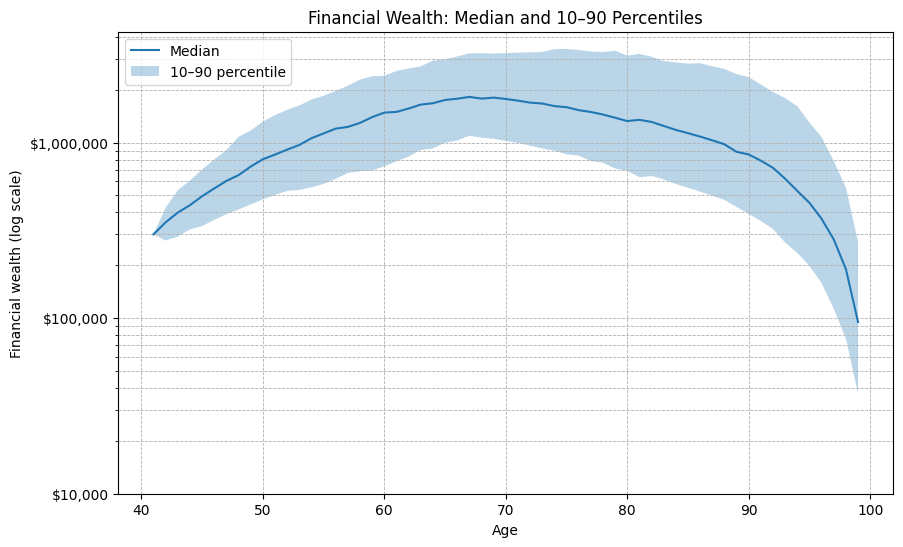

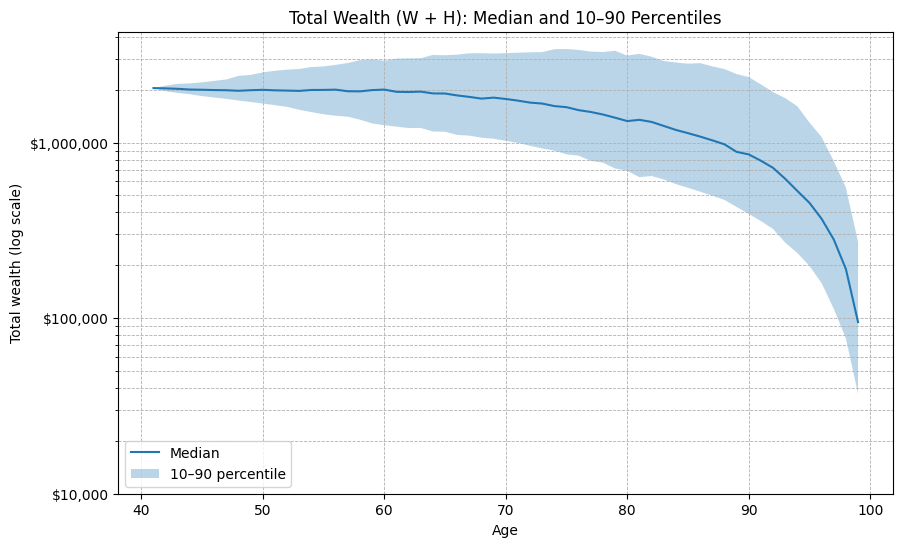

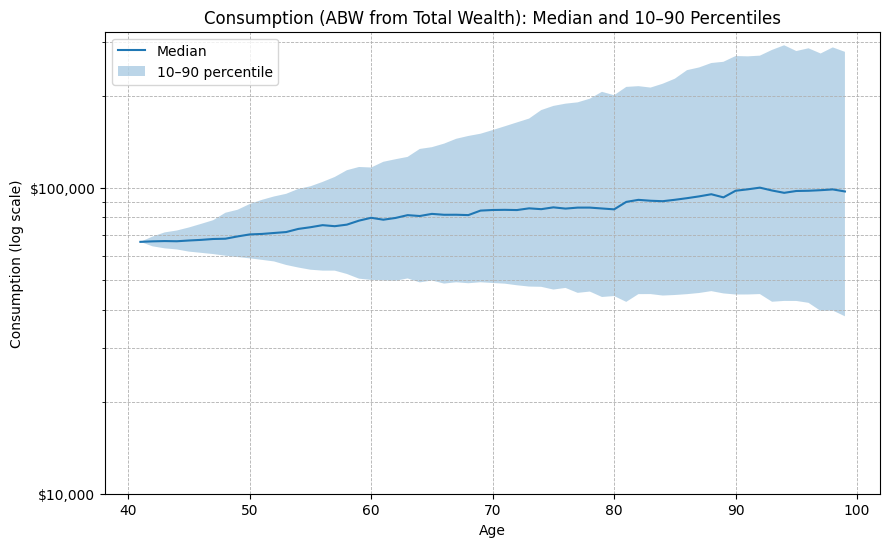

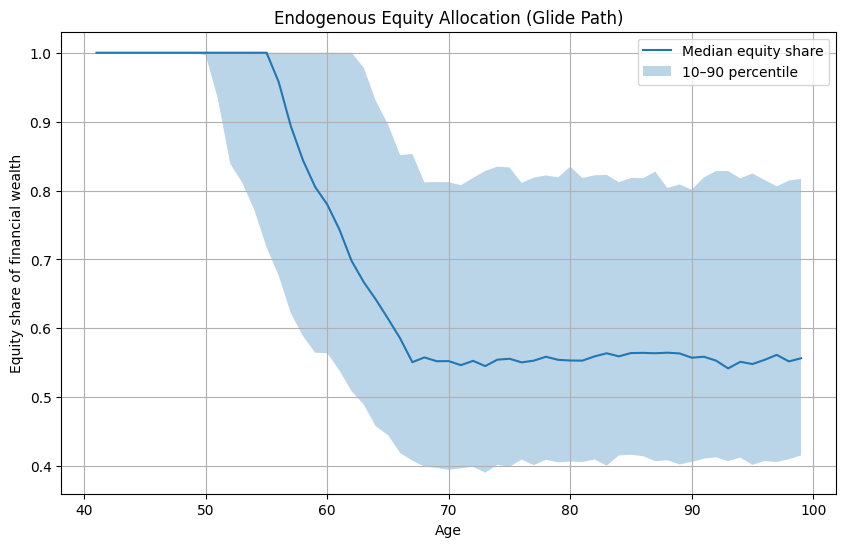

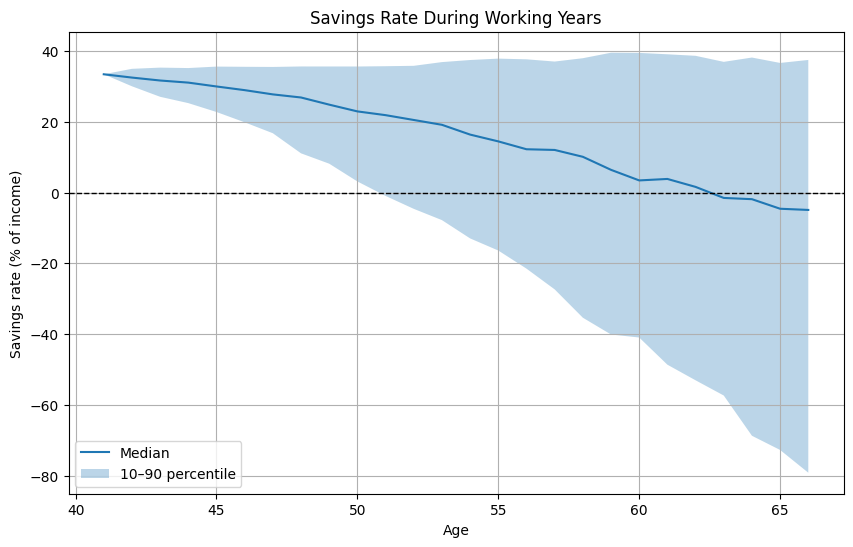

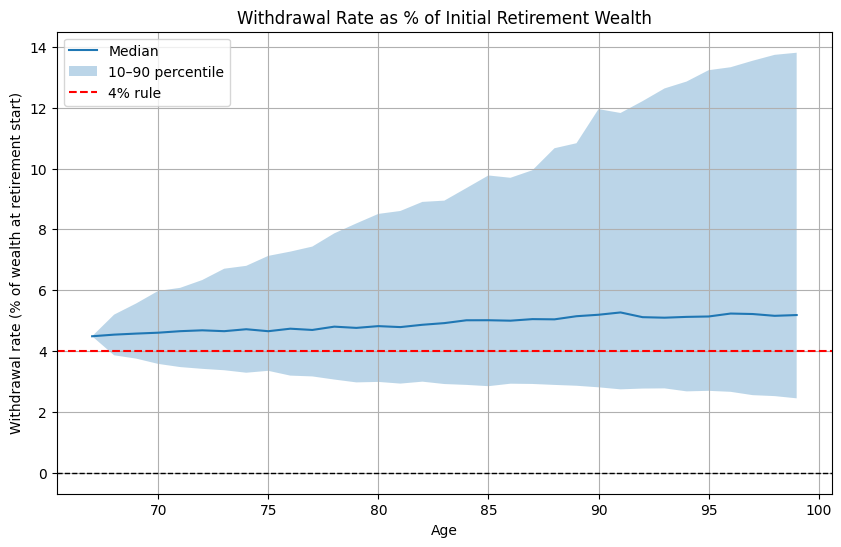

In [8]:
import matplotlib.ticker as mticker

def plot_with_bands_logy(ages, median, p10, p90, ylabel, title):
    eps = 1e-6
    med_clip = np.clip(median, eps, None)
    p10_clip = np.clip(p10, eps, None)
    p90_clip = np.clip(p90, eps, None)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ages, med_clip, label="Median")
    ax.fill_between(ages, p10_clip, p90_clip, alpha=0.3, label="10–90 percentile")

    # Log scale, with $1,000 lower bound
    ax.set_yscale("log")
    ax.set_ylim(bottom=10_000)

    # Dollar formatting, no exponents
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"${x:,.0f}")
    )
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10, numticks=10))

    ax.set_xlabel("Age")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.6)
    plt.show()


# 1. Financial wealth
plot_with_bands_logy(
    ages,
    W_med,
    W_p10,
    W_p90,
    ylabel="Financial wealth (log scale)",
    title="Financial Wealth: Median and 10–90 Percentiles",
)

# 2. Total wealth (W + H)
plot_with_bands_logy(
    ages,
    X_med,
    X_p10,
    X_p90,
    ylabel="Total wealth (log scale)",
    title="Total Wealth (W + H): Median and 10–90 Percentiles",
)

# 3. Consumption
plot_with_bands_logy(
    ages,
    C_med,
    C_p10,
    C_p90,
    ylabel="Consumption (log scale)",
    title="Consumption (ABW from Total Wealth): Median and 10–90 Percentiles",
)

# 4. Equity share (glide path) – linear scale
plt.figure(figsize=(10, 6))
plt.plot(ages, pi_med, label="Median equity share")
plt.fill_between(ages, pi_p10, pi_p90, alpha=0.3, label="10–90 percentile")
plt.xlabel("Age")
plt.ylabel("Equity share of financial wealth")
plt.title("Endogenous Equity Allocation (Glide Path)")
plt.legend()
plt.grid(True)
plt.show()

# 5. Savings rate during working years
working_mask = ages < age_retire

plt.figure(figsize=(10, 6))
plt.plot(ages[working_mask], sr_med[working_mask] * 100, label="Median")
plt.fill_between(
    ages[working_mask],
    sr_p10[working_mask] * 100,
    sr_p90[working_mask] * 100,
    alpha=0.3,
    label="10–90 percentile",
)
plt.axhline(0.0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Age")
plt.ylabel("Savings rate (% of income)")
plt.title("Savings Rate During Working Years")
plt.legend()
plt.grid(True)
plt.show()

# 6. Withdrawal rate as % of WEALTH AT START OF RETIREMENT
retirement_mask = ages >= age_retire

ages_ret   = ages[retirement_mask]
wr0_med_ret = wr0_med[retirement_mask]
wr0_p10_ret = wr0_p10[retirement_mask]
wr0_p90_ret = wr0_p90[retirement_mask]

plt.figure(figsize=(10, 6))
plt.plot(ages_ret, wr0_med_ret * 100, label="Median")
plt.fill_between(
    ages_ret,
    wr0_p10_ret * 100,
    wr0_p90_ret * 100,
    alpha=0.3,
    label="10–90 percentile",
)

# --- Add a 4% rule line ---
plt.axhline(4.0, color="red", linestyle="--", linewidth=1.5, label="4% rule")

plt.axhline(0.0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Age")
plt.ylabel("Withdrawal rate (% of wealth at retirement start)")
plt.title("Withdrawal Rate as % of Initial Retirement Wealth")
plt.legend()
plt.grid(True)
plt.show()



## Summary and Key Observations

- Consumption remains relatively stable in real terms across the entire lifecycle. This reflects the model’s objective of utility smoothing: individuals prefer a consistent standard of living rather than allowing consumption to fluctuate strongly with income or investment returns.

- During retirement, the model supports a variable withdrawal rate that is often higher (on average) than traditional "safe withdrawal rate" (SWR) estimates. This occurs even without assuming historically high U.S. equity returns. Because the withdrawal fraction adapts dynamically to wealth and expected returns, retirees draw more when markets perform well and moderate spending when they do not.

- A steep decline in equity exposure from near 100% early in life (when leverage is not allowed) toward a more conservative mix in retirement emerges naturally from the model. The final allocation depends on the risk-aversion parameter, $\gamma$. In most calibrations, the implied glide path is somewhat steeper than that of many target-date funds, reflecting both the declining role of human capital and the lack of borrowing early on.

- Consumption adjusts gradually to realized investment outcomes: it tends to decrease when returns are poor and increase when returns are strong. However, these adjustments are not one-for-one, because valuation-based updates to expected returns (through the CAPE process) smooth some of the immediate impact of short-term market shocks.

### Conceptual mapping between academic theory and ABW

| Notion | Merton (HJB) | ABW Approximation |
|:--|:--|:--|
| Consumption rule | $c_t=\kappa(t)X_t$ | $C_t=k(N_t,r_{\text{plan}})X_t$ |
| Human capital | PV of future income in HJB state | Deterministic NPV to retirement |
| Portfolio rule | $\pi_t=\frac{\mu-r}{\gamma\sigma^2}$ (adjusted for $H_t$) | Myopic rule with human capital, no hedging |
| Opportunity set | Constant or stochastic (hedging term) | CAPE-based $\mu_t$, no hedging term |
| Solution method | Solve PDE for $V(t,W)$ | Discrete simulation + ABW fraction |

- Deterministic discounting + no bequest ⇒ ABW rule.  
- Deterministic income ⇒ closed-form $H_t$.  
- Myopic CRRA rule ⇒ endogenous glide path.  
- CAPE dependence ⇒ state-dependent expected return.


## References

### Practical ABW info from the community

- **Bogleheads Wiki.** *Amortization-Based Withdrawal.* (accessed 2025)  
  <https://www.bogleheads.org/wiki/Amortization_based_withdrawal> | [Bogleheads home](https://www.bogleheads.org)  

---

### Core Theoretical Sources

- **Merton, R. C. (1969).** “Lifetime Portfolio Selection under Uncertainty: The Continuous-Time Case.” *The Review of Economics and Statistics*, 51(3), 247-257.  

- **Merton, R. C. (1971).** “Optimum Consumption and Portfolio Rules in a Continuous-Time Model.” *Journal of Economic Theory*, 3(4), 373-413.


- **Samuelson, P. A. (1969).** “Lifetime Portfolio Selection by Dynamic Stochastic Programming.” *The Review of Economics and Statistics*, 51(3), 239-246.

---

### Extensions and Lifecycle Literature

- **Bodie, Z., Merton, R. C., & Samuelson, W. F. (1992).** “Labor Supply Flexibility and Portfolio Choice in a Life Cycle Model.” *Journal of Economic Dynamics and Control*, 16(3-4), 427-449.


- **Cocco, J. F., Gomes, F. J., & Maenhout, P. J. (2005).** “Consumption and Portfolio Choice over the Life Cycle.” *Review of Financial Studies*, 18(2), 491-533.

- **Campbell, J. Y., & Viceira, L. M. (2002).** *Strategic Asset Allocation: Portfolio Choice for Long-Term Investors.* Oxford University Press.

---

### CAPE

- **Campbell, J. Y., & Shiller, R. J. (1988).** “The Dividend-Price Ratio and Expectations of Future Dividends and Discount Factors.” *Review of Financial Studies*, 1(3), 195-228.

- **Boudoukh, J., Israel, R., & Richardson, M. (2019).** “Long-Horizon Predictability: A Cautionary Tale.” *Financial Analysts Journal*, 75(1), 17-30.

- **Shiller, R. J. (2000).** *Irrational Exuberance.* Princeton University Press.

---

### Risk Aversion and Market-Implied Preferences

- **Friend, I., & Blume, M. E. (1975).** “The Demand for Risky Assets.” *American Economic Review*, 65(5), 900-922.

- **Chetty, R. (2006).** “A New Method of Estimating Risk Aversion.” *American Economic Review*, 96(5), 1821-1834.

- **Mehra, R., & Prescott, E. C. (1985).** “The Equity Premium: A Puzzle.” *Journal of Monetary Economics*, 15(2), 145-161.

- **Campbell, J. Y. & Cochrane, J. H. (1999).** “By Force of Habit: A Consumption-Based Explanation of Aggregate Stock Market Behavior.” *Journal of Political Economy*, 107(2), 205-251.



